## **ABOUT THE DATASET**
The following data is intended for advancing financial sentiment analysis research. It's two datasets (FiQA, Financial PhraseBank) combined into one easy-to-use CSV file. It provides financial sentences with sentiment labels.


# **IMPORTING LIBRARIES**

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **IMPORTING AND EXPLORING THE DATASET**

In [ ]:
# Mount the dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import the required library
import pandas as pd

# List all sheet names in the Excel file
xls = pd.ExcelFile('/content/drive/MyDrive/Sentiment_analysis_dataset.xlsx')
sheet_names = xls.sheet_names

# Print the sheet names
print(sheet_names)


['data']


In [ ]:
# Read the Excel file with the correct sheet name
df = pd.read_excel('/content/drive/MyDrive/Sentiment_analysis_dataset.xlsx', sheet_name='data')

# **INSPECTING THE DATA FRAME**

In [ ]:
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [ ]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [ ]:
print(df.isnull().sum())

Sentence     0
Sentiment    0
dtype: int64


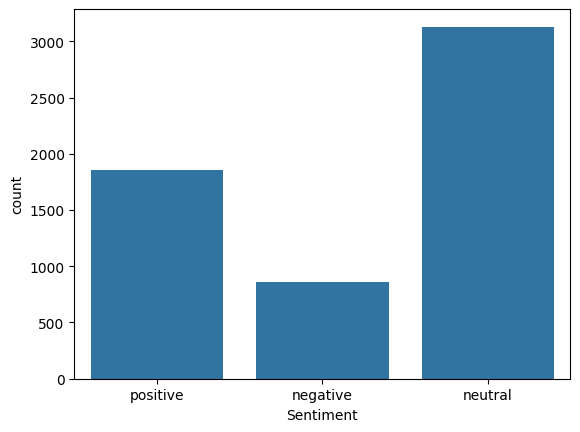

In [ ]:
sns.countplot(x ='Sentiment', data = df)
plt.show()

# **WORDCLOUD**

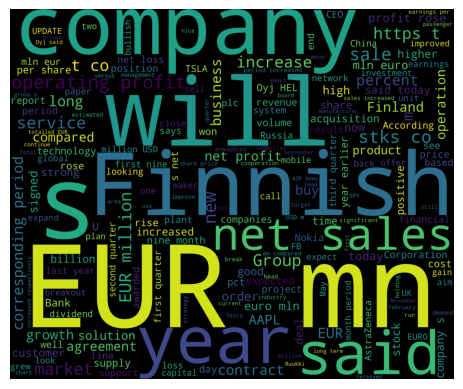

In [ ]:
# Sentiment Positive

df1 = df[df['Sentiment']=='positive']
words = ' '.join(df1['Sentence'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color='black',stopwords=STOPWORDS,
                      width=3000, height=2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

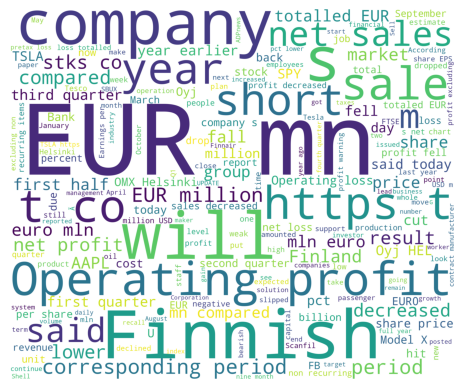

In [ ]:
# Sentiment Negative

df2 = df[df['Sentiment']=='negative']
words = ' '.join(df2['Sentence'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color='white',stopwords=STOPWORDS,
                      width=3000, height=2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

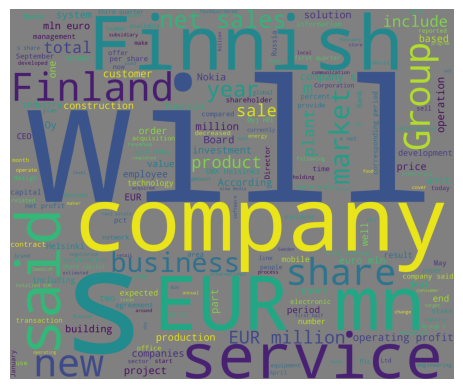

In [ ]:
# Sentiment Neutral

df3 = df[df['Sentiment']=='neutral']
words = ' '.join(df3['Sentence'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color='gray',stopwords=STOPWORDS,
                      width=3000, height=2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### **PREPROCESSING**

In [ ]:
#Count information per category
plot1=df.groupby(by=["Sentence","Sentiment"]).count().reset_index()
plot1

,Sentence,Sentiment
0,"#Apple breaks major support, here are some lev...",negative
1,#Apple up almost 20% from its February lows wi...,positive
2,#Fintech provider $CAFN Cachet Financial Solut...,positive
3,#FusionIQ NEW Positive Timing Signal on $SBUX ...,positive
4,#LongPos $TSLA 256 Break-out thru 50 & 200- DM...,positive
...,...,...
5831,volatility squeeze in $AAPL. I hope it gets re...,neutral
5832,what #stocks large players are selling http://...,negative
5833,what is up with $HK..... from Jan to now it's ...,negative
5834,www.countryelements.co.uk Designed by Patricia...,neutral


In [ ]:
def tweet_to_words(tweet):
    letters_only = re.sub('^[a-zA-Z]',' ',tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_word = [w for w in words if w not in stops]
    return ' '.join(meaningful_word)

In [ ]:
def tweet_len(tweet):
    letters_only = re.sub('^[a-zA-Z]',' ',tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_word = [w for w in words if w not in stops]
    return (len(meaningful_word))

In [ ]:
df['Sentiments'] = df['Sentiment'].apply(lambda x:0 if x=='negative' else 1)
df['clean_tweet'] = df['Sentence'].astype(str).apply(lambda x:tweet_to_words(x))
df['tweet_length'] = df['Sentence'].astype(str).apply(lambda x:tweet_len(x))
train_data, test_data = train_test_split(df,test_size=0.2,random_state=123)

In [ ]:
train_clean_tweet = []
for tweet in train_data['clean_tweet']:
    train_clean_tweet.append(tweet)
test_clean_tweet = []
for tweet in test_data['clean_tweet']:
    test_clean_tweet.append(tweet)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer='word')
train_features = v.fit_transform(train_clean_tweet)
test_features = v.transform(test_clean_tweet)

## MODEL **BUILDING**

In [ ]:
Classifiers = [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    GaussianNB(),
    CatBoostClassifier(verbose=False),
    SGDClassifier()]


In [ ]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train_data['Sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train_data['Sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test_data['Sentiment'])*100
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy) + '%')


Accuracy of LogisticRegression is 52.3524379811805%
Accuracy of KNeighborsClassifier is 52.18135158254918%
Accuracy of DecisionTreeClassifier is 59.19589392643285%
Accuracy of RandomForestClassifier is 62.61762189905903%
Accuracy of AdaBoostClassifier is 64.24294268605647%
Accuracy of GaussianNB is 52.5235243798118%
Accuracy of CatBoostClassifier is 66.72369546621043%
Accuracy of SGDClassifier is 64.92728828058169%


In [ ]:
result = pd.DataFrame({'Models':Model})
result['Accuracy'] = Accuracy
result = result.sort_values(by='Accuracy',ascending=False)
result

,Models,Accuracy
6,CatBoostClassifier,66.723695
7,SGDClassifier,64.927288
4,AdaBoostClassifier,64.242943
3,RandomForestClassifier,62.617622
2,DecisionTreeClassifier,59.195894
5,GaussianNB,52.523524
0,LogisticRegression,52.352438
1,KNeighborsClassifier,52.181352


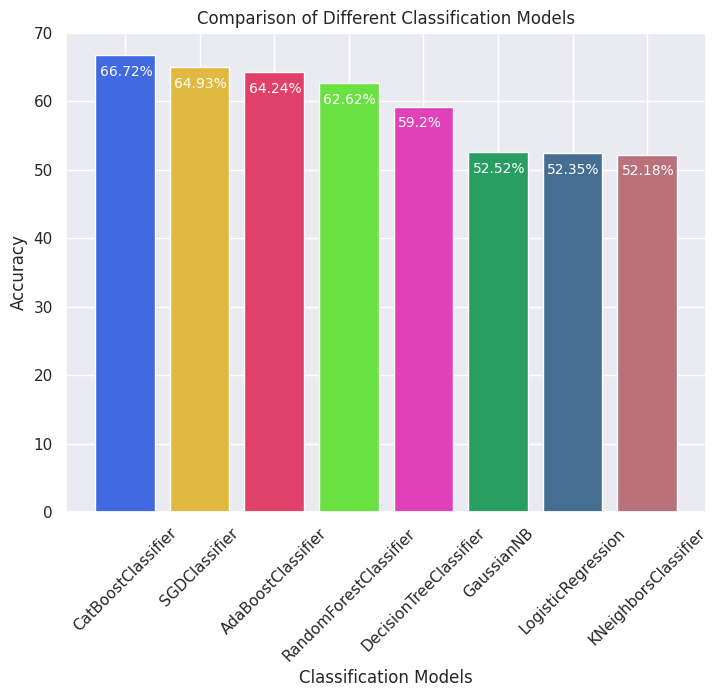

In [ ]:
import matplotlib.pyplot as plt

sns.set()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['CatBoostClassifier', 'SGDClassifier', 'AdaBoostClassifier', 'RandomForestClassifier',
          'DecisionTreeClassifier', 'GaussianNB', 'LogisticRegression', 'KNeighborsClassifier']
Accuracy= result['Accuracy']
ax.bar(Models,Accuracy,color=['#4169e1', '#e1b941', '#e14169', '#69e141','#e141b9','#289f61','#456e92', '#ba727a']);
for i in ax.patches:
    ax.text(i.get_x()+.06, i.get_height()-3.0, str(round(i.get_height(),2))+ '%', fontsize=10, color='white')
plt.title('Comparison of Different Classification Models');
plt.ylabel('Accuracy');
plt.xlabel('Classification Models')
plt.xticks(rotation=45);

plt.show();
